## Importing Libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mode
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE

## Reading the dataset

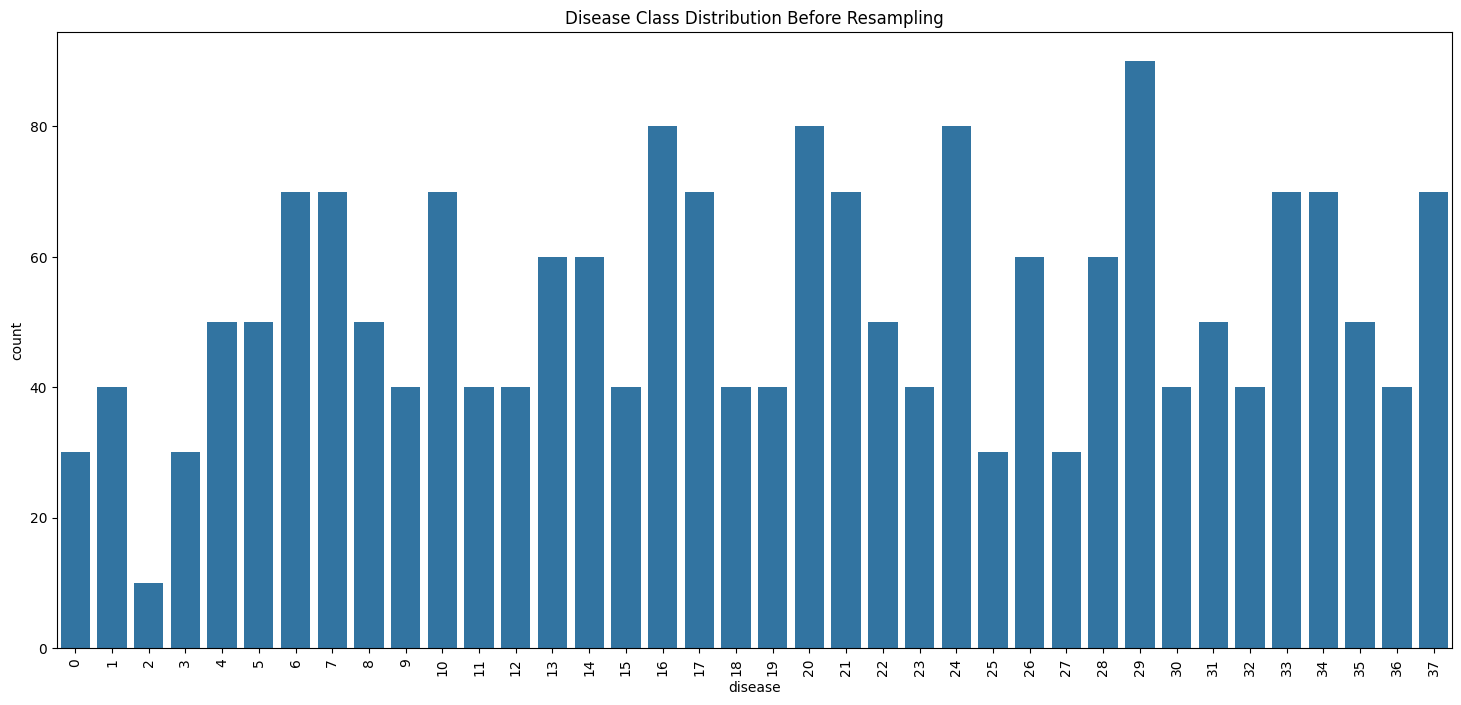

Resampled Class Distribution:
 disease
29    90
11    90
4     90
18    90
23    90
1     90
12    90
30    90
32    90
9     90
20    90
36    90
15    90
19    90
27    90
3     90
25    90
0     90
5     90
22    90
35    90
31    90
16    90
24    90
7     90
17    90
34    90
10    90
37    90
6     90
33    90
21    90
26    90
13    90
28    90
14    90
8     90
2     90
Name: count, dtype: int64


In [8]:
data = pd.read_csv("improved_disease_dataset.csv")

encoder = LabelEncoder()
data["disease"] = encoder.fit_transform(data["disease"])

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

plt.figure(figsize=(18, 8))
sns.countplot(x=y)
plt.title("Disease Class Distribution Before Resampling")
plt.xticks(rotation=90)
plt.show()

ros = SMOTE(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

print("Resampled Class Distribution:\n", pd.Series(y_resampled).value_counts())

## Cross-Validation with Stratified K-Fold

In [9]:
models = {
    "SVM": SVC(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier()
}

cv_scoring = "accuracy"
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for model_name, model in models.items():
  try:
    scores = cross_val_score(
        model,
        X_resampled,
        y_resampled,
        cv=stratified_kfold,
        scoring=cv_scoring,
        n_jobs=1,
        error_score="raise"
    )
    print("=" * 50)
    print(f"Model: {model_name}")
    print(f"Scores: {scores}")
    print(f"Mean Accuracy: {scores.mean():.4f}")
  except Exception as e:
    print("=" * 50)
    print(f"Model: {model_name} failed with error:")
    print(e)

Model: SVM
Scores: [0.51754386 0.52923977 0.56140351 0.51461988 0.47368421 0.50877193
 0.51461988 0.46491228 0.51754386 0.52631579]
Mean Accuracy: 0.5129
Model: Naive Bayes
Scores: [0.43859649 0.43274854 0.30116959 0.37134503 0.40350877 0.41520468
 0.43859649 0.4005848  0.48245614 0.44736842]
Mean Accuracy: 0.4132
Model: Random Forest
Scores: [0.51754386 0.53216374 0.5380117  0.50584795 0.48538012 0.52339181
 0.50877193 0.45321637 0.51461988 0.50584795]
Mean Accuracy: 0.5085


## Training Individual Models and Generating Confusion Matrices

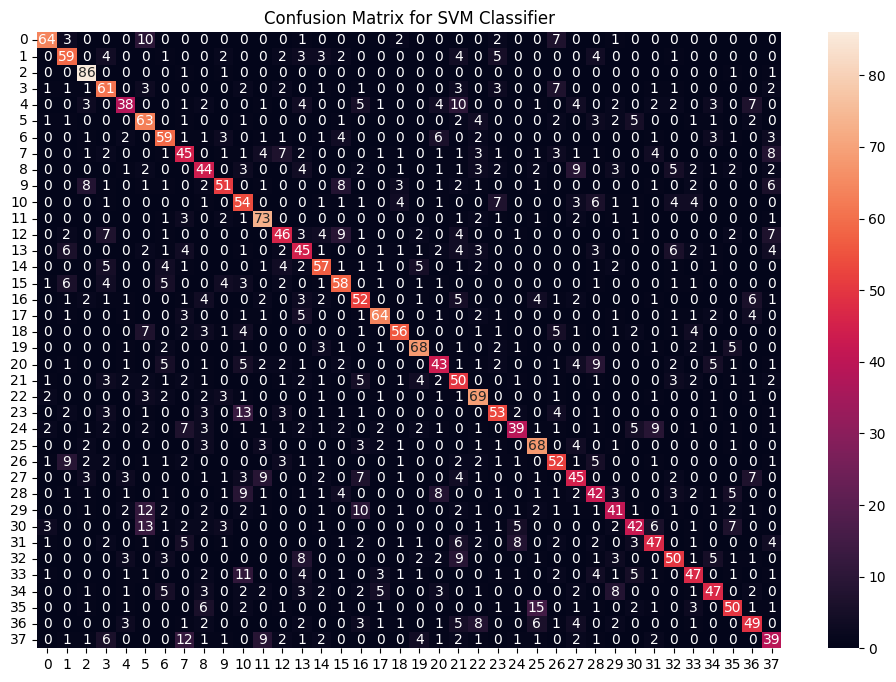

SVM Accuracy: 58.95%


In [10]:
svm_model = SVC()
svm_model.fit(X_resampled, y_resampled)
svm_preds = svm_model.predict(X_resampled)

cf_matrix_svm = confusion_matrix(y_resampled, svm_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cf_matrix_svm, annot=True, fmt="d")
plt.title("Confusion Matrix for SVM Classifier")
plt.show()

print(f"SVM Accuracy: {accuracy_score(y_resampled, svm_preds) * 100:.2f}%")

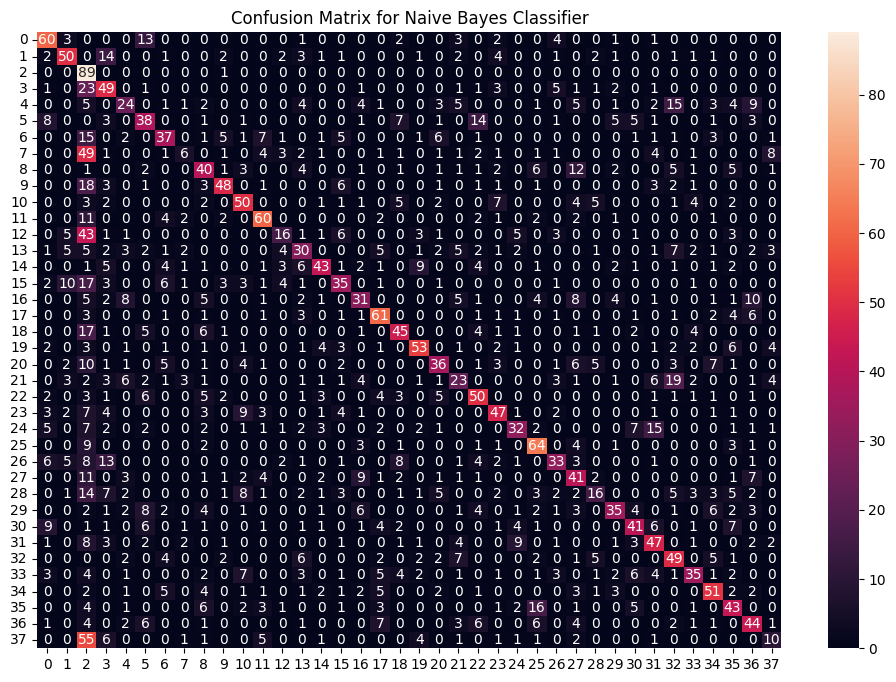

Naive Bayes Accuracy: 45.67%


In [11]:
nb_model = GaussianNB()
nb_model.fit(X_resampled, y_resampled)
nb_preds = nb_model.predict(X_resampled)

cf_matrix_nb = confusion_matrix(y_resampled, nb_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cf_matrix_nb, annot=True, fmt="d")
plt.title("Confusion Matrix for Naive Bayes Classifier")
plt.show()

print(f"Naive Bayes Accuracy: {accuracy_score(y_resampled, nb_preds) * 100:.2f}%")

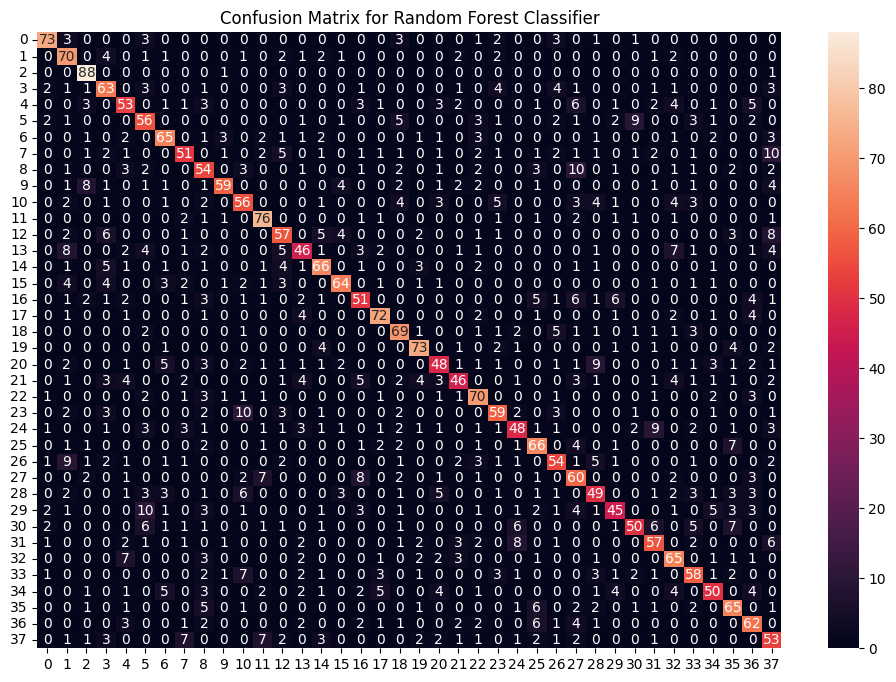

Random Forest Accuracy: 66.29%


In [12]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)
rf_preds = rf_model.predict(X_resampled)

cf_matrix_rf = confusion_matrix(y_resampled, rf_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cf_matrix_rf, annot=True, fmt="d")
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

print(f"Random Forest Accuracy: {accuracy_score(y_resampled, rf_preds) * 100:.2f}%")

## Combining Predictions for Robustness

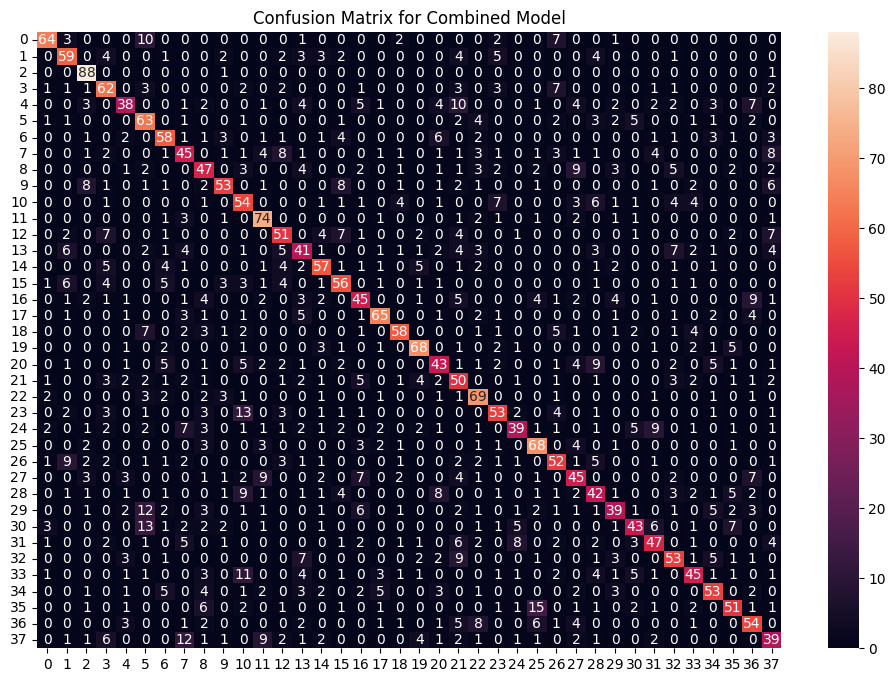

Combined Model Accuracy: 59.39%


In [13]:
from statistics import mode

final_preds = [mode([i, j, k]) for i, j, k in zip(svm_preds, nb_preds, rf_preds)]

cf_matrix_combined = confusion_matrix(y_resampled, final_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cf_matrix_combined, annot=True, fmt="d")
plt.title("Confusion Matrix for Combined Model")
plt.show()

print(f"Combined Model Accuracy: {accuracy_score(y_resampled, final_preds) * 100:.2f}%")

## Creating Prediction Function

In [14]:
symptoms = X.columns.values
symptoms_index = {symptom: idx for idx, symptom in enumerate(symptoms)}

def predict_disease(input_symptoms):
  input_symptoms = input_symptoms.split(",")
  input_data = [0] * len(symptoms_index)

  for symptom in input_symptoms:
    if symptom in symptoms_index:
      input_data[symptoms_index[symptom]] = 1

  input_data = pd.DataFrame([input_data], columns=symptoms)

  rf_pred = encoder.classes_[rf_model.predict(input_data)[0]]
  nb_pred = encoder.classes_[nb_model.predict(input_data)[0]]
  svm_pred = encoder.classes_[svm_model.predict(input_data)[0]]

  final_pred = mode([rf_pred, nb_pred, svm_pred])

  return {
      "Random Forest Prediction": rf_pred,
      "Naive Bayes Prediction": nb_pred,
      "SVM Prediction": svm_pred,
      "Final Prediction": final_pred
  }

In [15]:
print(predict_disease("Itching,Skin Rash,Nodal Skin Eruptions"))

{'Random Forest Prediction': 'Heart attack', 'Naive Bayes Prediction': 'Jaundice', 'SVM Prediction': 'Osteoarthritis', 'Final Prediction': 'Heart attack'}
